In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from build_dataset import build_dataset

In [3]:
from models.dnn_regression import DenseNeuralNetwork

Using TensorFlow backend.


In [4]:
ModelClass = DenseNeuralNetwork

In [5]:
# initialize some random models
models = ModelClass.random_models(10)
for model in models:
    print(model.model_options)

{'net': {'layers': [{}], 'loss': 'mse', 'optimizer': 'Adam', 'learning_rate': 0.01, 'epochs': 10, 'batch_size': 64, 'metrics': ['mse'], 'evaluation_criteria': {'minimize': False, 'threshold': 7.044069977852158}}, 'predict_n': 10}
{'net': {'layers': [{}], 'loss': 'mse', 'optimizer': 'Adamax', 'learning_rate': 0.001, 'epochs': 7, 'batch_size': 8, 'metrics': ['mse'], 'evaluation_criteria': {'minimize': False, 'threshold': 6.316257264046689}}, 'predict_n': 10}
{'net': {'layers': [{}], 'loss': 'mse', 'optimizer': 'Adam', 'learning_rate': 0.0001, 'epochs': 4, 'batch_size': 1, 'metrics': ['mse'], 'evaluation_criteria': {'minimize': False, 'threshold': 7.987919336473124}}, 'predict_n': 10}
{'net': {'layers': [{}], 'loss': 'mse', 'optimizer': 'Adadelta', 'learning_rate': 0.01, 'epochs': 1, 'batch_size': 8, 'metrics': ['mse'], 'evaluation_criteria': {'minimize': False, 'threshold': 4.5985609959569915}}, 'predict_n': 10}
{'net': {'layers': [{}], 'loss': 'mse', 'optimizer': 'Adam', 'learning_rate'

In [6]:
errors = []

In [7]:
iterations = 2

In [8]:
for i in range(iterations):
    errors = []

    for model_idx, model in enumerate(models):
        print("Iteration {0}, Model {1}".format(i + 1, model_idx + 1))
        
        # prepare the data
        x, y = build_dataset(model.input_options, model.model_options["predict_n"], True)
        # split the data into training set and testing set
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        # train the model
        model.train(x_train, y_train)
        # calculate the model error
        y_predict = model.predict(x_test)
        errors.append(model.error(y_test, y_predict))

    # select top models
    error_idx_sorted = np.argsort(errors)
    top_models = [models[i] for i in error_idx_sorted[:2]]

    # cross-over models and breed new models
    if i < iterations - 1:
        models = ModelClass.evolve(top_models, 10)

Iteration 1, Model 1
Epoch 1/10
2808/2808 [==============================] - 0s 106us/step - loss: 135950.1981 - mean_squared_error: 135950.1981
Epoch 2/10
2808/2808 [==============================] - 0s 14us/step - loss: 1527.5593 - mean_squared_error: 1527.5593
Epoch 3/10
2808/2808 [==============================] - 0s 20us/step - loss: 505.5193 - mean_squared_error: 505.5193
Epoch 4/10
2808/2808 [==============================] - 0s 16us/step - loss: 501.5053 - mean_squared_error: 501.5053
Epoch 5/10
2808/2808 [==============================] - 0s 17us/step - loss: 501.7556 - mean_squared_error: 501.7556
Epoch 6/10
2808/2808 [==============================] - 0s 17us/step - loss: 499.6006 - mean_squared_error: 499.6006
Epoch 7/10
2808/2808 [==============================] - 0s 17us/step - loss: 497.9881 - mean_squared_error: 497.9881
Epoch 8/10
2808/2808 [==============================] - 0s 17us/step - loss: 494.0119 - mean_squared_error: 494.0119
Epoch 9/10
2808/2808 [============

2808/2808 [==============================] - 0s 33us/step - loss: 1262.4056 - mean_squared_error: 1262.4056
Epoch 10/10
2808/2808 [==============================] - 0s 29us/step - loss: 1319.5610 - mean_squared_error: 1319.5610
Iteration 2, Model 1
Epoch 1/4
2808/2808 [==============================] - 1s 197us/step - loss: 458.5835 - mean_squared_error: 458.5835
Epoch 2/4
2808/2808 [==============================] - 0s 103us/step - loss: 457.6659 - mean_squared_error: 457.6659
Epoch 3/4
2808/2808 [==============================] - 0s 101us/step - loss: 457.5181 - mean_squared_error: 457.5181
Epoch 4/4
2808/2808 [==============================] - 0s 102us/step - loss: 457.1291 - mean_squared_error: 457.1291
Iteration 2, Model 2
Epoch 1/7
2808/2808 [==============================] - 0s 99us/step - loss: 464.5542 - mean_squared_error: 464.5542
Epoch 2/7
2808/2808 [==============================] - 0s 102us/step - loss: 463.5007 - mean_squared_error: 463.5007
Epoch 3/7
2808/2808 [========

In [9]:
best_model_idx = np.argmin(errors)
best_model = models[best_model_idx]
print(best_model.model_options)

{'net': {'layers': [{}], 'loss': 'mse', 'optimizer': 'Adam', 'learning_rate': 0.001, 'epochs': 7, 'batch_size': 8, 'metrics': ['mse'], 'evaluation_criteria': {'minimize': False, 'threshold': 6.316257264046689}}, 'predict_n': 10}


In [10]:
import pandas as pd

In [11]:
import matplotlib.pyplot as plt

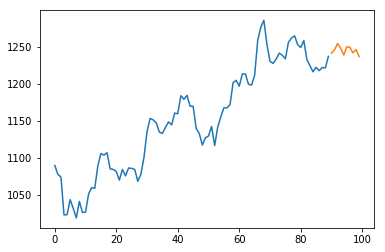

In [12]:
stock_prices = pd.read_csv("./data/stock_prices/" + model.stock_code + ".csv", index_col=0)["adjusted_close"].values[::-1]
stock_prices = stock_prices[-90:]
x = build_dataset(best_model.input_options, best_model.model_options["predict_n"], False)
prediction = best_model.predict(x)
plt.plot(np.arange(len(stock_prices)), stock_prices)
plt.plot(np.arange(len(stock_prices), len(stock_prices) + len(prediction)), prediction)